### Read training, dev and unlabeled test data

The following provides a starting code (Python 3) of how to read the labeled training and dev cipher text, and unlabeled test cipher text, into lists.

In [1]:
train, dev, test = [], [], []

In [2]:
for x in open('./train_enc.tsv', encoding='utf-8'):
    x = x.rstrip('\n\r').split('\t')
    # x[0] will be the label (0 or 1), and x[1] will be the ciphertext sentence.
    x[0] = int(x[0]) 
    train.append(x)
print (len(train))
print (train[:3])

16220
[[0, 'lkêcê yoúc cêêö y#êjl lw mówám Újám j Úêê# ütlk Úol lkêú z#ê ctöé8ú ówl xoóóú éê#xw#öê#c .'], [0, '6êcétlê jolêot8 zc éê#xw#öjóáê , tl zc j #jlkê# 8tcl8êcc jöÚ8ê 6wüó lkê öt668ê wx lkê #wj6 , ükê#ê lkê lkêöjltá t#wótêc j#ê lww wÚ2twoc jó6 lkê cê+oj8 éw8tltác lww cöoy .'], [0, 'tx lktc kw8t6jú öw2tê tc coééwcê6 lw Úê j ytxl , cwöêÚw6ú oóü#jééê6 tl êj#8ú , lwwm wol j88 lkê yww6 cloxx , jó6 8êxl Úêktó6 lkê á#jé ( 8tlê#j88ú ) .']]


In [3]:
for x in open('./dev_enc.tsv', encoding='utf-8'):
    x = x.rstrip('\n\r').split('\t')
    # x[0] will be the label (0 or 1), and x[1] will be the ciphertext sentence.
    x[0] = int(x[0]) 
    dev.append(x)
print (len(dev))
print (dev[:3])

2027
[[1, 'ów8jó Ú#j2ê8ú l#êj6c ükê#ê xêü jöê#tájó xt8öc 6j#ê lw 6ê82ê 77 tólw lkê üw#86 wx jöÚt2j8êóáê jó6 jöÚtyotlú <<<'], [0, 'ê2êó öo#ékú zc ê+éê#l áwötá ltötóy jó6 xjöê6 ákj#tcöj áj ózl #êcáoê lktc êxxw#l .'], [1, 'üt88 jcco#ê68ú #jóm jc wóê wx lkê á8ê2ê#êcl , öwcl 6êáêélt2ê8ú jöoctóy áwöê6têc wx lkê úêj# .']]


#### Different from 'train' and 'dev' that are both list of tuples, 'test' will be just a list.

In [4]:
for x in open('./test_enc_unlabeled.tsv', encoding='utf-8'):
    x = x.rstrip('\n\r')
    test.append(x)
print (len(test))
print (test[:3])

2028
['j 6t6jáltá jó6 6o88 6wáoöêólj#ú y8w#txútóy cwxlüj#ê jój#ákú .', 'ówlktóy cltámc , #êj88ú , ê+áêél j 8tóyê#tóy á#êêétóêcc wóê xêê8c x#wö Úêtóy 6#jyyê6 lk#woyk j cj6 , cw#6t6 oót2ê#cê wx yoóc , 6#oyc , j2j#táê jó6 6jöjyê6 6#êjöc .', 'öo#ékú jó6 üt8cwó jáloj88ú öjmê j é#êllú yww6 lêjö <<< Úol lkê é#wvêál co##woó6tóy lkêö tc 6tcl#êcctóy8ú #wlê .']


#### You can split every sentence into lists of words by white spaces.

In [5]:
train_split = [[x[0], x[1].split(' ')] for x in train]
dev_split = [[x[0], x[1].split(' ')] for x in dev]
test_split = [[x.split(' ')] for x in test]

### Main Code Body

You may choose to experiment with different methods using your program. However, you need to embed the training and inference processes at here. We will use your prediction on the unlabeled test data to grade, while checking this part to understand how your method has produced the predictions.

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Bidirectional, Attention
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
from keras import regularizers
import matplotlib.pyplot as plt
from keras_self_attention import SeqSelfAttention
%matplotlib inline

In [7]:
# Eventually, results need to be a list of 2028 0 or 1's
results = []

In [8]:
train_texts_split = [x[1] for x in train_split]
dev_texts_split = [x[1] for x in dev_split]
test_texts_split = [x[0] for x in test_split]

train_labels = [x[0] for x in train_split]
dev_labels = [x[0] for x in dev_split]

all_texts_split = train_texts_split + dev_texts_split + test_texts_split

In [9]:
# calculate max seq len
def get_max_seq_len(data):
    return max([len(seq) for seq in data])

# Setting the max_seq_len over all data
max_seq_len = get_max_seq_len(all_texts_split)

In [10]:
def create_vocabulary(data):
    vocab = set()
    for sentence in data:
        vocab = vocab.union(set(sentence))
    return vocab

In [11]:
vocab = create_vocabulary(all_texts_split)
vocab_size = len(vocab) + 1

In [12]:
# Tokenize the dataset
def get_padded_sequences(vocab, data, max_seq_len):
    tokenizer = Tokenizer(filters=[])
    tokenizer.fit_on_texts(vocab)
    seq = tokenizer.texts_to_sequences(data)
    seq_pad = pad_sequences(seq, maxlen=max_seq_len)
    return seq_pad

In [13]:
X_train = get_padded_sequences(vocab,train_texts_split, max_seq_len)
X_dev = get_padded_sequences(vocab, dev_texts_split, max_seq_len)
X_test = get_padded_sequences(vocab, test_texts_split, max_seq_len)

y_train = np.array(train_labels)
y_dev = np.array(dev_labels)

X_train_dev = np.concatenate((X_train, X_dev))
y_train_dev = np.concatenate((y_train, y_dev))

In [14]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 59, 32)            699712    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               106400    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 806,313
Trainable params: 806,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
127/127 [==============================] - 10s 37ms/step - loss: 8.5604 - accuracy: 0.5142 - val_loss: 1.1516 - val_accuracy: 0.5303
Epoch 2/100
127/127 [==============================] - 2s 17ms/step - loss: 0.7933 - accuracy: 0.5652 - val_loss: 0.6787 - val_accuracy: 0.6275
Epoch 3/100
127/127 [==============================] - 2s 17ms/step - loss: 0.5383 - accura

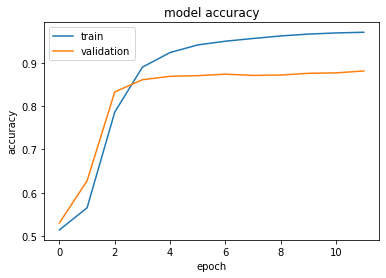

64/64 - 0s - loss: 0.4370 - accuracy: 0.8811
[0.4370401203632355, 0.8811050653457642]


In [15]:
def create_model(vocab_size, max_seq_len, embedding_len, dropout):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_len, input_length=max_seq_len))
    model.add(Bidirectional(LSTM(100, 
                                 dropout=dropout, 
                                 kernel_regularizer=regularizers.l2(l2=0.1), 
                                 recurrent_regularizer=regularizers.l2(l2=0.1))))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    return  model

early_stoping_callback = EarlyStopping(patience=5)
tensorboard_callback = TensorBoard()

callbacks = [
    early_stoping_callback,
    tensorboard_callback
]

model_checkpoint_callback = ModelCheckpoint(monitor='val_accuracy',filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5')

model = create_model(vocab_size, max_seq_len, 32, 0.3)

history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_dev, y_dev), verbose=1,
                   callbacks=callbacks)

plot_history(history)

scores = model.evaluate(X_dev, y_dev, verbose=2)
print(scores)

In [16]:
results = model.predict(X_test)
results = [1 if(x > 0.5) else 0 for x in results]
print(len(results))

2028


### Output Prediction Result File

You will need to submit a prediction result file. It should have 2028 lines, every line should be either 0 or 1, which is your model's prediction on the respective test set instance.

In [17]:
# suppose you had your model's predictions on the 2028 test cases read from test_enc_unlabeled.tsv, and 
#those results are in the list called 'results'
assert (len(results) == 2028)

In [18]:
# make sure the results are not float numbers, but intergers 0 and 1
results = [int(x) for x in results]

In [19]:
# write your prediction results to 'upload_predictions.txt' and upload that later
with open('upload_predictions.txt', 'w', encoding = 'utf-8') as fp:
    for x in results:
        fp.write(str(x) + '\n')